# Einleitung
In der Bildverarbeitung stellt neben der Bildbearbeitung und der Computergrafik auch der Bereich der Computer Vision eine sehr große Rolle. Neben dem puren Erkennen von Objekten, stellt der Bereich der Tiefenwertberechnung ein weiteres komplexes Feld. Dabei werden Informationen aus einem oder mehreren Bildern dazu verwendet einen 2D-Punkt auf einem Bild einem 3D Punkt in der realen Welt zuzuordnen. Um die Auswertung zu erleichtern können auch Tiefensensoren verwendet werden. So wird zum Beispiel bei der Azure Kinect neben einer Kamera auch ein Tiefensensor verwendet um eine 3D-Konstruktion des Raumes oder die Pose eines Menschens zu erfassen.

Im Folgenden wird die Zuhilfenahme solcher Sensoren jedoch nicht berücksichtigt und sich einzig auf die Verwendung von korresponierenden Punkten in zwei Bildern beschränkt. Zudem wurde die verwendete Kamera mittels eines Kalibrierungsmusters kalibriert und daraus deren Kameramatrix berechnet.


In ihrem Buch _Multiple View Geometry_, beschreiben Hartley und Zisserman in Algorithmus 12.1 ein Verfahren, das mittels Triangulierung aus einem korrespondierenden 2D-Punktpaar einen möglichst genauen 3d-Punkt bestimmt. Dieser wurde im Folgenden implementiert.

# Epipolargeometrie
Die hier zu Grunde liegende Theorie stammt aus der Epipolargeometrie. So wird jeder der beiden Punktlochkameras jeder 3D-Punkt durch die Linse auf den 2D Sensor projiziert insofern dieser im Sichtfeld liegt.

![Epipolargeometrie](img/Epipolargeometrie3.png)
<br/>Abb. 1: Grundlagen der Epipolargeometrie [[Wikipedia]](https://upload.wikimedia.org/wikipedia/commons/3/33/Epipolargeometrie3.svg).


Ein Bildpunkt $X$ wird dabei auf die Punkte $X_R$ und $X_L$ projiziert, indem ein Strahl von X zum jeweiligen Projektionszentrum $O$ führt. Dies entspricht z.B. einem Lichtstrahl, der ausgehend von $X$ durch die Linse der Kamera auf den Sensor trifft.
Die Bildebene auf der die Bildpunkte liegen sind dann die jeweiligen Sensoren der Kameras.

Angenommen es wäre nur ein Bild verfügbar, so kann nicht genau bestimmt werden, wo $X$ im zweiten Bild liegen würde.

Ist nun aber die Translation und Rotation der beiden Kameras zueinander bekannt, so kann der sog. Epipol bestimmt werden.
Dieser gibt an, wo sich das jeweils andere Kamerazentrum im eigenen Bild (auf der Bildebene) befindet. Somit geben die Epipole (gelb) $e_L$ und $e_R$ die Projektion des rechten und linken Kamerazentrums auf die Bildebenen 1 und 2 an.

Daraus kann dann mittels $X_L$ bzw. $X_R$ und dem jeweiligen Epipol eine Epipolarlinie gebildet werden, auf der alle Punkte der Epipolarebene liegen.
Aus den Vektoren $\vec{Oe_L}$ und $\vec{OX_L}$ lässt sich dann mittels Kreuzprodukt eine Normale $\vec{Oe_L}\times\vec{OX_L}$ bilden, für die dann wiederum $\vec{OX_L} \cdot (\vec{Oe_L} \times \vec{OX_L}) = 0$ gelten muss (senkrecht zueinander). Dieser Zusammenhang wird als _Epipolar Constraint_ bezeichnet. Analog dazu auch bei der rechten Seite.

Diese Relation kann dann als
$$X_l^T\cdot T \cdot R \cdot X_r = 0$$
beschrieben werden, wobei $R$ die Rotation und $T$ die Rotation der linken zur rechten Kamera beschreiben und $X_l$ und $X_r$ Punkte im 3D Raum beschreiben.
Weiter kann dann $R$ und $T$ als Essential Matrix $E = T\cdot R$ zusammengefasst werden. Durch dieses Verhältnis lassen sich nun 3D-Punkte aus dem Koordinatensystem von Kamera L zu dem von Kamera R und umgekehrt durch $E^{-1}$ berechnen. Eine Umkehrung von $E$ mittels SVD ist einfach möglich, da $T$ schiefsymmetrisch und $R$ orthonormal ist.

Da $X_L$ und $X_L$ 3D-Punkte sind, die in den meisten Fällen nicht bekannt sein sollten, muss die Formel soweit umgeformt werden, sodass die 2D-Bildpunkte $x_L = [x_{L1},x_{L2}, 1]^T$ und $x_R = [x_{R1},x_{R2}, 1]^T$ transformiert werden können. Dafür wird die Projektion eines 3D-Punktes auf die 2D Bildebene benötigt. Diese Information enthält die Kameramatrix, auch Projektionsmatrix genannt. Da auch diese Parameter bei einem Bildpaar konstant sind, wird aus den beiden Kameramatrizen $K_L$, $K_R$ und der Essentiellen Matrix dann die Fundamentalmatrix $F$ gebildet. Somit gilt $E = K^T_LFK_R$. Eine Kalibrierung der Kamera und die Berechnung der Kameramatrix ist z.B. mittels eines Kalibrierungsmusters möglich. Dazu aber mehr im Kapitel Kalibrierung.

$$ x_L^T \cdot K_L^{-T} \cdot E \cdot K_R^{-1} \cdot x_R = x_L^T \cdot F \cdot x_R = 0 $$

Diese Fundamentalmatrix projiziert somit einen Punkt des linken Bildes auf einen Punkt des rechten Bildes.

# Problemstellung
In der Theorie gilt die oben gezeigte Epipolar Constraint immer für korrespondierende Punkte. Dies ist in der Realität durch Distortion, ungenaue Punkte, etc. häufig allerdings nicht der Fall. Schon bei einer minimalen Abweichung laufen die beidem Vektoren $\vec{x} = \vec{OX_L}$ und $\vec{x'} = \vec{OX_R}$ aneinander vorbei und bilden keinen Schnittpunkt $X$. Damit dennoch ein möglichst guter Punkt $X$ im dreidimensionalen Raum berechnet werden kann, kommt das Prinzip der Triangulierung ins Spiel. Ein relativ einfacher Algorithmus zur Triangulierung eines Punktes $X$ würde die zwei Vektoren aufstellen und dann zum Beispiel mittels Lotverfahren die Punkte auf beiden Vektoren bestimmen, an der der Abstand minimal ist. Der Mittelpunkt dieser beiden Punkte würde dann als triangulierter Schnittpunkt $X$ gelten.

[[1]](#paper) sehen das allerdings als eher ungenau an und schlagen den _Optimalen Triangulierungsalgorithmus (12.1)_ vor.
Dieser verwendet die Fundamentalmatrix um aus korrespondierenden Punktpaaren $x \leftrightarrow x'$ eine Fundamentalmatrix zu konstruieren, für die die Epipolarbedingung zutrifft und somit besser geeignete homogene Punktpaare $\hat{x} \leftrightarrow \hat{x}'$ zu finden und diese dann zur Berechnung von $X$ zu verwenden.

# Experiment
## Vorbereitung
Es wurde ein Smartphones als Kamera verwendet, wobei eine Szene aus 10 unterschiedlichen Betrachtungswinkeln erfasst wurde und darauf geachtet, dass auch die selbe der 3 Hauptkameras ohne Zoom verwendet wurde. Die erlangten Fotos waren im $4:3$ Format mit einer Auflösung von $3648 \times 2736 px$, welche nicht weiter skaliert wurde. Die Szene blieb während des gesamten Experiments unverändert, einzig die Kamera wurde im Abstand von ca. 60 bis 150cm Abstand um die Szene herum frei bewegt.


### Kalibrierung
[[1]](#paper) geben an, dass entweder die Kameramatrizen oder $F$ bekannt sein soll. Zur einfacheren Berechnung von $X$ im letzten Schritt des Algorithmus, wurden beide Kameras mittels `OpenCV` kalibriert. Die erforderlichen Kameramatrizen könnten vermutlich auch mittels einer Konstruktion via DLT und gemessenen 3D-Punkten ermittelt werden.

Dafür wurde ein Schachbrettmuster mit $8x6$ Kacheln ausgedruckt, vermessen und in die Szene gelegt. Anschließend wurden die 10 Bilder mit der Kamera gemacht. Der weiße Rand wurde nicht entfernt, da dieser laut _OpenCV's_ Dokumentation bessere Ergebnisse liefert.

Für jedes Bild wird dann mittels _OpenCV's_ `cv2.findChessboardCorners` die Ecken des Schachbretts identifiziert, wobei die Äußersten nicht Teil der Kalibrierung sind. Anschließend werden alle Ecken an die Kalibrierungsfunktion `cv2.calibrateCamera` übergeben. Diese ermittelt dann die intrinsische Kameramatrix, als auch die Rotations- und Translationsvektoren, sowie die Distortion der einzelnen Bilder. Da das verwendete Smartphone bereits über eine gute Korrektur der Verzerrung verfügt, werden die Bilder nicht zusätzlich entzerrt. Dies ist aber dennoch für den weiteren Verlauf zu empfehlen. Die Randlänge der einzelnen Kacheln von ca. $\frac{23.3cm}{8 Kacheln} = 2.915cm$ wird ebenfalls übergeben.

Aus den intrinsischen $3\times3$ Kameramatrizen $K$ und $K'$, und den bildspezifischen Translations ($t$)- und Rotationsvektoren($r$) wird dann die $3 \times 4$ Projektionsmatrizen $P$ und $P'$ berechnet, wobei die Rotationsmatrix $R$ mittels Rodrigues Rotationsformel aus $r$ ermittelt wird.

$$ P = K \cdot W = K \cdot [R|t] $$

Diese beiden Projektionsmatrizen werden daraufhin dem implementierten Triangulierungsalgorithmus als Parameter übergeben.

### Fundamentalmatrix
Zur Berechnung des Algorithmus wird eine initiale Fundamentalmatrix benötigt. Diese wird durch Verwenden der _OpenCV_ Funktion `cv2.findFundamentalMat` und den gefundenen Schachbrett-Punktpaaren ($n=35$) konstruiert.

![Bilder mit Punkten](assets/generated/with-markers.jpg)
<br/>Abb. 2: Das verwendete Bildpaar mit eingezeichneten Punkten und Verbindungslinien.

Des Weiteren wurde in einem vorherigen Versuch versucht analog zu [[2]](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) mittels SIFT und Graubildern, korrespondierende Bildpunkte zu ermitteln.

Aufgrund doch einiger fehlerhaften Zuordnungen (s. Abb.3) wurden vorerst die Eckpaare verwendet. Die in [Kalibrierung](#kalibrierung) verwendeten Ecken, sind aber je nach Bild bzw. Betrachtungswinkel auch nicht in der selben Reihenfolge, welche vor der weiteren Verwendung noch korrigiert werden muss. Im Beispiel wurden zwei Bilder verwendet, die bereits die selbe Sortierung der Eckpunkte, als auch einen merklich anderen Blickwinkel aufweisen.

Eine Berechnung aus den kalibrierten Kameramatrizen hätte auch verwendet werden können [[1]](#paper).

![Sift](assets/sift.jpg "sift Punkte und Epipolarlinien")
<br/>Abb. 3: Mittels SIFT erkannte Bildpunkte und berechnete Epipolarlinien (_OpenCV_).

## Optimaler Triangulierungsalgorithmus
### Allgemeiner Ablauf
Zum Start wurden die bereits erwähnten Bilder geladen, die Kameramatrizen berechnet und die korrespondierenden Punkte extrahiert.

Im Anschluss wurde mittels `HZTriangulation` eine Klasse für den Algorithmus mit den o.g. Parametern initialisiert. Bei der Initialisierung wird die Fundamentalmatrix $F$ anhand der gegebenen Punkte berechnet. Das oben gezeigte Bild in Abb.2 wird hier anhand der gegebenen Bilder und Punkte mit Markern zur leichteren Auswertung gespeichert.

Für jedes 2D-Punktpaar wird der triangulierte 3D-Punkt `X` berechnet und in eine Tabelle gespeichert.
Zum Vergleich wird auch versucht über die eingebaute OpenCV Funktion `cv2.triangulatePoints`, die selben Punkte aus den gegebenen Punktpaaren zu ermitteln. 

### Schritte für Punktpaare (Algorithmus)
Die Funktion `hz.singlePointStep(i)` nimmt jedes einzelne Punktpaar und evaluiert hier den 3D-Punkt X, sodass die Epipolarbedingung erfüllt ist.

Hierbei wird analog zu Hartley und Zisserman folgende Schritte ausgeführt:
#### Erstellen von $T$ und $T'$ aus $x$ und $x'$
Wenn beide Bildpunkte mit den Epipolen korrespondieren, so liegen beide Punkte auf einer Linie zwischen den beiden Kamerazentren. Somit wäre es unmöglich, die genaue Position auf dieser Linie zu bestimmen. Deshalb wird hier angenommen, dass keiner der Bildpunkte auf dieser Linie liegt[[1]](#paper). Durch den Versuchsaufbau ist dies zudem nicht möglich, da sich die Kameras nicht gegenseitig sehen.

Die Autoren merken zudem an, dass wenn nur ein Punkt auf dieser Linie liegt, sich dieser Punkt im Zentrum des anderen Kamerazentrums befinden muss. Deshalb gehen sie davon aus, dass keiner der beiden Bildpunkte auf einem Epipol liegt.

Somit können die beiden Bildpunkte auf den Ursprung $(0,0,1)^T$ mittels der Translationsmatrizen $T$ und $T'$ für $x$ und $x'$ verschoben werden.

$$ T = \begin{bmatrix}
1 &   & -x\\
  & 1 & -y \\
  &   & 1
\end{bmatrix},
T' = \begin{bmatrix}
1 &   & -x'\\
  & 1 & -y'\\
  &   & 1
\end{bmatrix} $$

#### Anwendung der Translation auf $F$
Aufgrund der Translation der Bildpunkte in den Ursprung, muss diese auch auf die Fundamentalmatrix angewendet werden, es wird $F$ (`hz.Fp`) neu berechnet.
$$ F' = {T'}^{-T} F T^{-1} $$

#### Berechnen der Epipole
Um die Epipole $e$ und $e'$ im nächsten Schritt so zu rotieren, dass diese sich auf der $x$-Achse in den Punkten $(1,0,f)^T$ und $(1,0,f')^T$ befinden, werden die Epipole mittels SVD berechnet und anschließend so skaliert, dass $e^2_1 + e^2_2 = 1$ gilt.

#### Berechnung der Rotationsmatrizen
Durch die berechneten Epipole können nun die Rotationsmatrizen $R$ und $R'$ aufgestellt werden.
$$ R = \begin{bmatrix}
e_1 & e_2 &  \\
-e_2 & e_1 & \\
  &   & 1
\end{bmatrix} , R' = \begin{bmatrix}
e_1' & e_2' &  \\
-e_2' & e_1' & \\
  &   & 1
\end{bmatrix}  $$

Durch die Normalisierung gilt nun $Re = (1,0,e_3)^T$ und $R'e' = (1,0,e'_3)^T$.
Die nun gebildeten Rotationsmatrizen rotieren somit die Epipole an die gewünschten Positionen $(1,0,f)^T$ und $(1,0,f')^T$ auf der $x$-Achse.

#### Anwendung der Rotation auf $F'$
Analog zur Translation muss auch die Rotation der Bildpunkte in der Fundamentalmatrix widergespiegelt werden. Dies geschieht durch:
$$ F'' = R'F'R^T $$
Die Form der Fundamentalmatrix liegt somit in der in [[1, (12.3)]](#paper) beschriebenen speziellen Form vor:
$$ F'' = \begin{bmatrix}
ff'd & -f'c & -f'd \\
-fb  & a    &  b   \\
-fd  & c    &  d
\end{bmatrix}
$$

#### Setzen von Parametern
Aufgrund der vorliegenden Form von $F''$ können die folgenden Parameter abgeleitet werden:
$$ f = e3 \\ f' = e'_3 \\ a = {F''}_{22} \\ b = {F''}_{23} \\ c = {F''}_{32} \\ d = {F''}_{33}  $$

#### Berechnen von Extrema
Hartley und Zisserman verwenden nun den quadratischen Abstand (Squared Distance) um den Abstand $d^2$ einer Linie $l(t)$ durch den Punkt $(0,t,1)^T$ und den Epipol $(1,0,f)^T$ zum Ursprung in Abhängigkeit von t im linken Bild zu berechnen. Um die selbe Linie auch im rechten Bild zu erhalten wird die neue Fundamentalmatrix $F''$ verwendet, sodass $l'(t) = {F''}\cdot(0,t,1)^T$. Auch hier wird eine Formel zur Berechnung des quadratischen Abstands aufgestellt.

Addiert man beide Abstandsgleichungen, so wird der Abstand minimal, wenn die Ableitung ein Minimum besitzt ($s'(t) = 0$).
Die aus der Ableitung erhaltene polynomische Formel $g(t) = 0$ wird nun verwendet um 6 Nullstellen (roots) zu finden.

#### Berechnen der Kosten und $t_{min}$
Der Realteil der berechneten Nullstellen t wird nun in die Kostenfunktion (Summe der quadratischen Abstände $s(t)$) eingesetzt. Das $t$ mit den geringsten Kosten wird als $t_{min}$ gewählt.

Somit ist die Linie $l(t)$ bei $t_{min}$ am nächsten zu den beiden Ursprüngen bzw. der Punkt $(0,t_{min}, 1)$ der Optimale zum Aufspannen von $l$ und $l'$.

#### Ermitteln von $\hat{x}$ und $\hat{x}'$
Nun werden die optimalen Punkte $\hat{x}$ und $\hat{x}'$ gesucht. Diese weisen die kürzeste Distanz zum Ursprung auf, da $x$ und $x'$ im jeweiligen Ursprung liegen und deshalb auch nach dem Abstand zu dem jeweiligen Ursprung minimiert wurden.

Dafür werden die zum Ursprung nächsten Punkte $\hat{x} = l(t_{min})$ und $\hat{x} = l'(t_{min})'$ genutzt um die zum Ursprung nächste Gerade mittels $(a,b,c) \rightarrow (-ac,-bc, a^2+b^2)$ aufzustellen.

#### Retransformation von $\hat{x}$ und $\hat{x}'$
Die zu Beginn vorgenommen Translationen und Rotationen werden nun an $\hat{x} = T^{-1}R^T\hat{x}$ und $\hat{x}' = {T'}^{-1}{R'}^T\hat{x}'$ rückgängig gemacht.

Die optimierten Koordinaten bleiben homogene Koordinaten.

#### Berechnung von $\hat{X}$
Um nun den 3D-Punkt $\hat{X}$ zu berechnen muss eine Projektion von 2D-Punkten zu 3D-Weltpunkten erfolgen.

Die von den Autoren genannte Option nennt die Direct Linear Transformation als Möglichkeit die intrinsischen und extrinsischen Eigenschaften zu schätzen.

Im Implementierungsbeispiel wurden allerdings die kalibrierten Kameramatrizen verwendet um $A$ aufzustellen und mittels SVD zu lösen.
Die resultierende homogene 3D Koordinate wurde normalisiert, sodass $\hat{X}_4 = 1$.

# Ergebnisse
Zusätzlich zu den berechneten 3D Punkten mit der o.g. Methode, wurden diese auch via _OpenCV's_ `cv2.triangulatePoints` ermittelt. Die folgende Ergebnistabelle _Tab. 1_ listet diese auf und zeichnet die Punkte der Reihe nach in einen Graphen _Abb. 4_, woraus sich das ursprüngliche Schachbrett erahnen lässt. Des Weiteren wurde die euklidische Entfernung jedes Punktes zur Position beider Kamerazentren $\widetilde{C_1}$ und $\widetilde{C_2}$ als Tiefe berechnet.

Um das Kamerazentrum $C$ und die inhomogene Version $\widetilde{C}$ zu berechnen, können folgende Gleichungen verwendet werden [[10]](#10).

$$
x = det([col_2, col_3, col_4]) \\ 
y =-det([col_1, col_3, col_4]) \\
z = det([col_1, col_2, col_4]) \\
h =-det([col_1, col_2, col_3]) \\
C = [x,y,z,h]^T \\
\widetilde{C} = [x/h, y/h, z/h]^T
$$


|    |    X (1) |   Y (1) |    Z (1) |   Tiefe C1 (1) |   Tiefe C2 (1) |   X (2) |   Y (2) |    Z (2) |   Tiefe C1 (2) |   Tiefe C2 (2) |
|---:|---------:|--------:|---------:|---------------:|---------------:|--------:|--------:|---------:|---------------:|---------------:|
|  0 | 1084.47  | 783.09  | -1175.88 |        981.346 |        789.914 | 680.265 | 217.884 | -526.988 |       107.985  |        483.806 |
|  1 | 1060.63  | 774.432 | -1161.91 |        956.926 |        760.97  | 684.514 | 220.221 | -528.49  |       107.664  |        483.631 |
|  2 | 1037.56  | 765.957 | -1148.46 |        933.55  |        732.968 | 688.541 | 222.685 | -530.134 |       107.662  |        483.232 |
|  3 | 1014.97  | 757.675 | -1135.28 |        910.911 |        705.549 | 692.402 | 225.313 | -531.912 |       107.946  |        482.616 |
|  4 |  993.163 | 749.656 | -1122.56 |        889.307 |        679.073 | 696.062 | 228.076 | -533.864 |       108.559  |        481.76  |
|  5 |  971.713 | 741.725 | -1110.09 |        868.326 |        653.036 | 699.515 | 231.024 | -535.979 |       109.469  |        480.634 |
|  6 |  950.552 | 733.866 | -1097.81 |        847.904 |        627.352 | 702.78  | 234.182 | -538.308 |       110.712  |        479.205 |
|  7 | 1106.13  | 779.485 | -1196.76 |       1004.05  |        816.421 | 679.663 | 217.137 | -522.668 |       104.783  |        486.498 |
|  8 | 1080.96  | 770.408 | -1181.93 |        978.016 |        785.832 | 684.081 | 219.358 | -524.149 |       104.373  |        486.473 |
|  9 | 1056.79  | 761.67  | -1167.73 |        953.284 |        756.477 | 688.277 | 221.688 | -525.757 |       104.289  |        486.246 |
| 10 | 1032.97  | 752.919 | -1153.81 |        929.16  |        727.53  | 692.363 | 224.196 | -527.564 |       104.547  |        485.788 |
| 11 | 1010.12  | 744.506 | -1140.48 |        906.295 |        699.777 | 696.197 | 226.815 | -529.505 |       105.123  |        485.103 |
| 12 |  987.287 | 736.12  | -1127.14 |        883.719 |        672.034 | 699.856 | 229.652 | -531.671 |       106.046  |        484.11  |
| 13 |  965.318 | 728.042 | -1114.31 |        862.284 |        645.344 | 703.298 | 232.637 | -533.977 |       107.262  |        482.881 |
| 14 | 1127.45  | 774.338 | -1217.72 |       1026.32  |        842.487 | 679.082 | 216.72  | -518.229 |       101.391  |        489.086 |
| 15 | 1100.89  | 764.859 | -1202    |        998.603 |        810.195 | 683.638 | 218.812 | -519.744 |       100.949  |        489.173 |
| 16 | 1075.53  | 755.673 | -1187.08 |        972.415 |        779.377 | 688.033 | 221.028 | -521.288 |       100.75   |        489.138 |
| 17 | 1050.43  | 746.576 | -1172.3  |        946.759 |        748.864 | 692.285 | 223.406 | -523.083 |       100.96   |        488.836 |
| 18 | 1026.16  | 737.889 | -1157.95 |        922.231 |        719.354 | 696.321 | 225.916 | -525.056 |       101.53   |        488.288 |
| 19 | 1002.73  | 729.328 | -1144.2  |        898.839 |        690.876 | 700.139 | 228.551 | -527.229 |       102.47   |        487.484 |
| 20 |  979.682 | 720.998 | -1130.62 |        876.121 |        662.858 | 703.717 | 231.374 | -529.576 |       103.72   |        486.387 |
| 21 | 1148.94  | 767.989 | -1238.84 |       1048.62  |        868.715 | 678.253 | 216.552 | -513.666 |        97.8879 |        491.498 |
| 22 | 1121.04  | 758.118 | -1222.25 |       1019.26  |        834.784 | 683.07  | 218.536 | -515.142 |        97.3127 |        491.784 |
| 23 | 1094.12  | 748.515 | -1206.28 |        991.213 |        802.053 | 687.66  | 220.629 | -516.763 |        97.1178 |        491.859 |
| 24 | 1067.89  | 739.224 | -1190.68 |        964.167 |        770.154 | 692.08  | 222.866 | -518.528 |        97.2657 |        491.729 |
| 25 | 1042.47  | 730.16  | -1175.6  |        938.245 |        739.242 | 696.292 | 225.231 | -520.491 |        97.8071 |        491.351 |
| 26 | 1017.85  | 721.326 | -1161.02 |        913.431 |        709.303 | 700.305 | 227.74  | -522.612 |        98.6841 |        490.74  |
| 27 |  993.727 | 712.574 | -1146.79 |        889.425 |        679.975 | 704.11  | 230.402 | -525     |        99.9818 |        489.822 |
| 28 | 1169.83  | 760.021 | -1259.61 |       1070.06  |        894.135 | 677.405 | 216.708 | -509.008 |        94.2215 |        493.786 |
| 29 | 1140.88  | 750.087 | -1242.2  |       1039.37  |        858.928 | 682.361 | 218.538 | -510.489 |        93.5834 |        494.212 |
| 30 | 1112.08  | 739.934 | -1225.01 |       1009.12  |        823.903 | 687.179 | 220.526 | -512.152 |        93.3388 |        494.421 |
| 31 | 1084.81  | 730.388 | -1208.69 |        980.778 |        790.74  | 691.776 | 222.618 | -513.889 |        93.4289 |        494.468 |
| 32 | 1058.19  | 720.957 | -1192.82 |        953.399 |        758.365 | 696.165 | 224.837 | -515.842 |        93.9426 |        494.257 |
| 33 | 1032.22  | 711.861 | -1177.29 |        927.013 |        726.792 | 700.365 | 227.194 | -518.044 |        94.8905 |        493.773 |
| 34 | 1007.15  | 702.837 | -1162.42 |        901.838 |        696.311 | 704.326 | 229.702 | -520.339 |        96.1134 |        493.068 |

Tab. 1: Korrespondierende 3D Punkte, berechnet via _Hartley-Zisserman's_ (1) und _OpenCV's_ (2) Methode

![plot hz](assets/generated/3d-hz-triangulated.jpg) ![plot cv](assets/generated/3d-cv-triangulated.jpg)
<br/> Abb. 4: Visualisierung der in Tab. 1 gegebenen Punkte (links (1), rechts (2)).

# Auswertung

## Tiefenwerte
Bei den Tiefenwerten in _Tab. 1_ fällt auf, dass sich diese zwischen $848$ und $1070$ für Kameraposition 1 und $627$ und $894$ für Position 2 bewegen. Da die Kameramatrix in mm kalibriert wurde, entspricht dies einer Entfernung von ca. $85$ bis $107cm$ und $63$ bis $89cm$. Dies liegt beides im Rahmen der realen Werte. Die Kamera beim rechten Bild befand sich etwas näher zum Kalibrierungsmuster als beim Linken. Ein Unterschied von $20cm$ ist hier als realistisch anzusehen.

Bei der Betrachtung der Ergebnisse des _OpenCV_ Algorithmus fällt auf, dass hierbei die Werte deutlich geringer ausgefallen sind. So war das Muster im linken Bild im Schnitt nur $10cm$ und im rechten $49cm$ entfernt. Beide Werte sind deutlich außerhalb des realen Rahmens und auch ihr Verhältnis zueinander um den Faktor $5$ war in der Realität nicht zu beobachten.

Dennoch liefern beide Methoden, die Werte in einem akzeptablen Rahmen, ohne richtige Ausreißer. So ist zum Beispiel für die linke Kamera (C1) die Standardabweichung im Verhältnis zum Mittelwert bei beiden Methoden ähnlich ($\frac{56.1}{948}=5.92%$ für _HZ_ und $\frac{5.17}{101}=5.09%$ für _OpenCV_). Bei Kamera 2 sind die Werte dennoch leicht unterschiedlich mit $8.97%$ und $0.888%$. Da sich die zweite Kameraposition näher befand, ist bei gleicher Größe des Musters allerdings auch eine Höhere Schwankung der Entfernung zu rechen.

## Entfernungen
Die Maße des Schachbrettblattes entsprechen denen eines herkömmlichen Din A4 Blattes ($297 mm x 210 mm$). Die Seiten des Schachbretts vermessen circa $233mm x 175mm$. Evaluiert man die euklidische Distanz zwischen den einzelnen Punkten ergeben sich die Ergebnisse aus _Tab. 2_. Hierbei entspricht der Faktor $1.00$ einer Länge von $29.125mm$, der Kantenlänge eines Quadrats.

|   from |   to |   distance (1) |   factor (1) |   distance (2) |   factor (2) |
|-------:|-----:|---------------:|-------------:|---------------:|-------------:|
|      0 |    1 |        28.9587 |     0.993438 |        5.07595 |     0.174132 |
|      1 |    2 |        28.0135 |     0.961013 |        4.99952 |     0.17151  |
|      2 |    3 |        27.4326 |     0.941083 |        4.99724 |     0.171432 |
|      3 |    4 |        26.489  |     0.908713 |        4.9835  |     0.170961 |
|      4 |    5 |        26.0493 |     0.893631 |        5.00948 |     0.171852 |
|      5 |    6 |        25.6955 |     0.881492 |        5.10453 |     0.175112 |
|      6 |    7 |       189.936  |     6.51583  |       32.7036  |     1.12191  |
|      7 |    8 |        30.5932 |     1.04951  |        5.16172 |     0.177074 |
|      8 |    9 |        29.3587 |     1.00716  |        5.06115 |     0.173624 |
|      9 |   10 |        28.9489 |     0.993101 |        5.12413 |     0.175785 |
|     10 |   11 |        27.7548 |     0.952137 |        5.03228 |     0.172634 |
|     11 |   12 |        27.7444 |     0.95178  |        5.11163 |     0.175356 |
|     12 |   13 |        26.692  |     0.915677 |        5.10612 |     0.175167 |
|     13 |   14 |       197.797  |     6.7855   |       32.9812  |     1.13143  |
|     14 |   15 |        32.292  |     1.10779  |        5.23793 |     0.179689 |
|     15 |   16 |        30.8175 |     1.0572   |        5.15835 |     0.176959 |
|     16 |   17 |        30.5134 |     1.04677  |        5.19184 |     0.178108 |
|     17 |   18 |        29.5098 |     1.01234  |        5.1459  |     0.176532 |
|     18 |   19 |        28.4792 |     0.976989 |        5.12297 |     0.175745 |
|     19 |   20 |        28.0182 |     0.961172 |        5.12575 |     0.17584  |
|     20 |   21 |       206.322  |     7.07794  |       33.485   |     1.14871  |
|     21 |   22 |        33.9343 |     1.16413  |        5.41507 |     0.185766 |
|     22 |   23 |        32.7355 |     1.123    |        5.29859 |     0.18177  |
|     23 |   24 |        31.9029 |     1.09444  |        5.25929 |     0.180422 |
|     24 |   25 |        30.9175 |     1.06063  |        5.21419 |     0.178874 |
|     25 |   26 |        29.9467 |     1.02733  |        5.18575 |     0.177899 |
|     26 |   27 |        29.3377 |     1.00644  |        5.22177 |     0.179134 |
|     27 |   28 |       214.458  |     7.35704  |       34.0066  |     1.16661  |
|     28 |   29 |        35.2162 |     1.2081   |        5.48728 |     0.188243 |
|     29 |   30 |        35.0446 |     1.20221  |        5.47097 |     0.187683 |
|     30 |   31 |        33.18   |     1.13825  |        5.34121 |     0.183232 |
|     31 |   32 |        32.3966 |     1.11137  |        5.29146 |     0.181525 |
|     32 |   33 |        31.5925 |     1.08379  |        5.29583 |     0.181675 |
|     33 |   34 |        30.5129 |     1.04676  |        5.21997 |     0.179073 |
|     34 |    0 |       112.245  |     3.85062  |       27.6188  |     0.947471 |

_Tab. 2_: Entfernung der Punkte zum jeweils Nachfolgenden, (1) für _HZ_, (2) für _OpenCV_.

Hierbei fällt auf, vor allem bei Hartley-Zisserman's Ansatz der Faktor bei den meisten Werten gegen $1.00$ läuft. Die maximale Abweichung beträgt hier ca. $21%$ von Punkt $28$ auf $29$. Die Diagonalen zwischen den einzelnen Reihen - ersichtlich aus _Abb. 4_ - sind mit Faktor $6.51$ bis $7.35$ (erwartet $\frac{178mm}{29.125mm} = 6.11$) leicht über dem erwarteten Wert. Der Sprung vom letzten zum ersten Punkt ist hierbei allerdings wesentlich kleiner, als erwartet ($Faktor > 6.11 $). Dies könnte auf eine Krümmung des projizierten Musters schließen lassen.

Beim _OpenCV_ Ansatz scheint, analog zu den Tiefenwerten, die Skalierung nicht richtig zu stimmen. Korrigiert man dies un nimmt beispielsweise $0.172$ als Faktor $1.00$, so sind ähnliche Phänomene wie im _HZ_ Algorithmus zu finden. Lediglich die Diagonale am Ende scheint etwas länger, aber trotzdem zu kurz zu sein.

## Flächeninhalt
Da im vorherigen Teil eine Krümmung der berechneten Punkte vermutet wurde, wird im Folgenden der Flächeninhalt genauer analysiert. Dabei wurde in _Tab. 3_ der Flächeninhalt auf drei Weisen berechnet.
(1) mittels 2 Dreiecken gespannt über die view Eckpunkte mit Kante vom Ersten zum Letzten Punkt (_Abb. 4_), (2) mittels 2 Dreiecken gespannt über die vier Eckpunkte mit Kante zwischen den beiden anderen Eckpunkten und (3) mittels vielen Dreiecken zwischen benachbarten Punkten, ähnlich zu einem Polygon Mesh.

Bei (3) wurde pro Reihe jeder Punkt mit dem nächsten der Reihe und dem darüber liegenden Punkt verknüpft, sowie der darüber Liegende mit dem nächsten der Reihe und der darüber liegenden Reihe verknüpft.

Die Auswertung ergab hierbei, dass die einfachen Ansätze (1) und (2) keine signifikanten Unterschiede aufwiesen, also keine große Verzerrung zu beobachten ist. Allerdings ist der daraus berechnete Flächeninhalt nur ca. $54%$ im Vergleich zum Erwarteten. Aufgrund der bereits festgestellten mangelnden Skalierung bei _OpenCV_ ist auch hier die Abweichung deutlich höher.

Bei Ansatz (3) sollte sich der Flächeninhalt nur minimal von (1) oder (2) abweichen, insofern alle Punkte auf der selben Ebene liegen. Da der Flächeninhalt bei Beiden jedoch deutlich höher ausfällt ($69%$ bei _HZ_), liegt eine Krümmung vor. Ob diese gleichmäßig ausgefallen ist, bräuchte eine detailliertere Auswertung.

## Weitere Bildpaare
Zusätzlich zu (3,4) wurden noch Bildpaare aus $(1,2)$, $(5,6)$, und $(9,10)$ überprüft und die Werte in _Abb. 5_ zusammengefasst.

In [255]:
points_cv = hz.triangulateOpenCv().T
for i in range(0,points_cv.shape[0]):
    points_cv[i] = points_cv[i]/points_cv[i,-1]
points_cv

array([[ 680.26544,  217.88412, -526.98773,    1.     ],
       [ 684.5136 ,  220.22124, -528.4898 ,    1.     ],
       [ 688.54126,  222.68526, -530.13354,    1.     ],
       [ 692.4018 ,  225.31303, -531.9122 ,    1.     ],
       [ 696.06165,  228.07582, -533.8635 ,    1.     ],
       [ 699.5152 ,  231.02432, -535.97876,    1.     ],
       [ 702.78015,  234.18214, -538.3078 ,    1.     ],
       [ 679.6634 ,  217.13728, -522.6676 ,    1.     ],
       [ 684.0811 ,  219.35805, -524.14923,    1.     ],
       [ 688.2766 ,  221.68762, -525.7574 ,    1.     ],
       [ 692.36316,  224.19588, -527.56445,    1.     ],
       [ 696.19727,  226.81493, -529.5046 ,    1.     ],
       [ 699.85596,  229.65196, -531.67114,    1.     ],
       [ 703.2983 ,  232.63663, -533.9765 ,    1.     ],
       [ 679.08167,  216.72035, -518.22894,    1.     ],
       [ 683.6385 ,  218.81233, -519.74384,    1.     ],
       [ 688.0333 ,  221.02794, -521.2882 ,    1.     ],
       [ 692.2851 ,  223.4063 ,

Hier wurden die 3D Koordinaten mittels `cv.triangulatePoints` ermittelt.

Auch hier liegen die Absolutwerte ähnlich weit weg von der erwarteten Entfernung in $z$ Richtung und auch in die anderen beiden Richtungen.

Dies ist sogar noch extremer bemerkbar beim Betrachten der Abstände der Blattecken. Ein korrektes Verhältnis zwischen den Abständen ist auch hier nicht zu erkennen.

Auffällig ist, dass die meisten $z$-Werte hier positiv sind und sich über $x$ und $y$ mit positiven und negativen Werten mehr verteilen. 

 0 =>  1:   5.0759 (0.17)
 1 =>  2:   4.9995 (0.17)
 2 =>  3:   4.9972 (0.17)
 3 =>  4:   4.9835 (0.17)
 4 =>  5:   5.0095 (0.17)
 5 =>  6:   5.1045 (0.18)
 6 =>  7:  32.7036 (1.12)
 7 =>  8:   5.1617 (0.18)
 8 =>  9:   5.0612 (0.17)
 9 => 10:   5.1241 (0.18)
10 => 11:   5.0323 (0.17)
11 => 12:   5.1116 (0.18)
12 => 13:   5.1061 (0.18)
13 => 14:  32.9812 (1.13)
14 => 15:   5.2379 (0.18)
15 => 16:   5.1584 (0.18)
16 => 17:   5.1918 (0.18)
17 => 18:   5.1459 (0.18)
18 => 19:   5.1230 (0.18)
19 => 20:   5.1257 (0.18)
20 => 21:  33.4850 (1.15)
21 => 22:   5.4151 (0.19)
22 => 23:   5.2986 (0.18)
23 => 24:   5.2593 (0.18)
24 => 25:   5.2142 (0.18)
25 => 26:   5.1858 (0.18)
26 => 27:   5.2218 (0.18)
27 => 28:  34.0066 (1.17)
28 => 29:   5.4873 (0.19)
29 => 30:   5.4710 (0.19)
30 => 31:   5.3412 (0.18)
31 => 32:   5.2915 (0.18)
32 => 33:   5.2958 (0.18)
33 => 34:   5.2200 (0.18)
34 =>  0:  27.6188 (0.95)
mean:    9.035615
median:  5.1918416
std:     9.481287
max:     34.006573
min:     4.98350

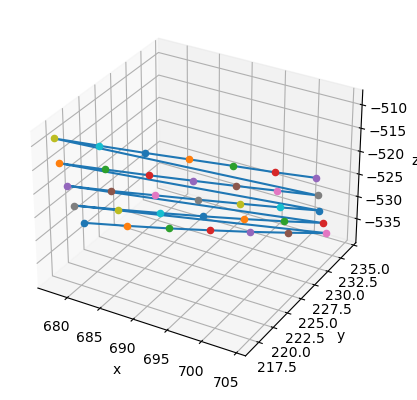

In [191]:
utils.evaluate_points(points_cv, calibrator.size_of_chessboard_squares_mm)
utils.plot_3d(points_cv)

# Diskussion
Der hier gezeigte Algorithmus ist stark von den gewählten Punkten und der Kamerakalibrierung abhängig.
Da auch im _OpenCV_ Ansatz einige Unstimmigkeiten zu finden sind, lässt dies auf ein Problem bei den Eingangsparametern schließen.

Eine mögliche Erklärung könnten einige ungenaue Angabe der korrespondierenden Punkte dienen. Jedoch brachte die Verwendung von SIFT in ersten Versuchen keine merkliche Besserung.

Eine weitere und sehr wahrscheinliche Ursache könnte die Kalibrierung der Kamera darstellen. Da beim Kalibrieren, das Blatt nicht allzu stark bewegt wurde und vor allem wenig seitlich gekippt, können die Projektionsmatrizen den Grund für die großen Unterschiede darstellen.
Desweiteren war das verwendete Blatt nicht besonders stabil und bildete somit manchmal eine leichte Krümmung.
Es wird daher empfohlen die Kalibrierung erneut durchzuführen.

Desweiteren kann eine Verzerrung durch die Kamera einen großen Einfluss auf die Triangulierung haben, weshalb ein Entzerren während der Kalibrierung ebenfalls eine Lösung darstellen könnte.

Zusätzlich war das Muster des verwendeten Schachbrett quadratisch, was eventuell auch einen Einfluss auf die Kalibrierung der Kamera haben könnte. Dazu konnte aber aktuell noch nichts gefunden werden.

# Quellen
<a id="paper"></a> [1] Hartley/Zisserman, Multiple View Geometry, p.310-318

[2] https://www.youtube.com/watch?v=UZlRhEUWSas

[3] https://en.wikipedia.org/wiki/Triangulation_(computer_vision)

[4] https://gist.github.com/cr333/0d0e6c256f93c0ed7bd2

[5] https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/autonomous-vision/lectures/computer-vision/

[6] https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

[7] https://www.changjiangcai.com/files/text-books/Richard_Hartley_Andrew_Zisserman-Multiple_View_Geometry_in_Computer_Vision-EN.pdf

[8] https://medium.com/@insight-in-plain-sight/estimating-the-homography-matrix-with-the-direct-linear-transform-dlt-ec6bbb82ee2b

[9] https://glowingpython.blogspot.com/2011/06/svd-decomposition-with-numpy.html

<a id="10"></a> [10] Vorlesungsfolien Bildverstehen, A. Siebert